## The Battle of Neighborhoods

In [1]:
#Import all the modules necessary
import pandas as pd

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import folium

import requests
from bs4 import BeautifulSoup

import lxml.html as lh

import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import webbrowser
import os

### Defined Functions 

In [2]:
# Get Latitudes and Longitudes
def getLocation(address, unique_places):
    
    latitude = []
    longitude = []
    places = []

    for i in range(len(address)):
        try:
            geolocator = Nominatim(user_agent="foursquare_agent")
            location = geolocator.geocode(address[i], language = 'en', timeout = 24)
            latitude.append(location.latitude)
            longitude.append(location.longitude)
            places.append(unique_places[i])

        except AttributeError:
            pass
        except GeocoderTimedOut:
            pass
        
    return(latitude, longitude, places)

In [3]:
#Build a Map
def build_map(area, zoom, latitude, longitude, place):
    
    geolocator = Nominatim(user_agent = 'foursquare_agent')
    location = geolocator.geocode(area, language = 'en')
    lat = location.latitude
    long = location.longitude
    
    mapA = folium.Map(location = [lat, long], zoom_start = zoom)
    
    for lat, lng, label in zip(latitude, longitude, place):
        folium.CircleMarker([lat, lng], radius = 5, color = 'blue', popup = label, fill = True, fill_color = 'blue', fill_opacity = 0.6).add_to(mapA)
        
        
    display(mapA)

In [4]:
#Observed Venues

def getNearbyVenues(names, lati, long, radius = 500, limit = 100):
    venues_list = []
    for name, lat, lng in zip(names, lati, long):
        
        #Create the API requests URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        #Making the get Request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        #Return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
                
    nearby_venues.columns = ['Area Name', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



### FourSquare Credentials

In [5]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'G0Z44BXYHPTIMJ3KM0S40VH5QULQBK2EYJ0FER2CZWQEG2Q2' # your Foursquare ID
CLIENT_SECRET = '1WOYHFDY05OQZGTQ23OVFWPXYABQV2SSX4UV4SMHT2TC15XK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G0Z44BXYHPTIMJ3KM0S40VH5QULQBK2EYJ0FER2CZWQEG2Q2
CLIENT_SECRET:1WOYHFDY05OQZGTQ23OVFWPXYABQV2SSX4UV4SMHT2TC15XK


### Japan Information

In [6]:
#Read Japan csv file
df_japan = pd.read_csv('Japan Postal Codes.csv')
df_japan.head()

,Country Code,City Name,Secondary City Name,Low,High
0,JP,Tokyo,Chiyoda,1000000,1000014
1,JP,Tokyo,Chiyoda,1006001,1029999
2,JP,Tokyo,Chuo,1030000,1049999
3,JP,Tokyo,Minato,1050000,1089999
4,JP,Tokyo,Taito,1100000,1119999


In [7]:
#Clean df_japan dataframe
df_japan.drop('Country Code', axis = 1, inplace = True)
df_japan = df_japan[df_japan['City Name'] == 'Tokyo']
df_japan.drop(['Low', 'High'], axis = 1, inplace = True)

df_japan.head()

,City Name,Secondary City Name
0,Tokyo,Chiyoda
1,Tokyo,Chiyoda
2,Tokyo,Chuo
3,Tokyo,Minato
4,Tokyo,Taito


In [8]:
#Add Address Column to df_japan
address_jap = df_japan['Secondary City Name'] + ' ' + df_japan['City Name'] + ' ' + 'Japan'
df_japan['Address'] = address_jap
#df_japan.drop(['City Name', 'Secondary City Name'], axis = 1, inplace = True)

df_japan.sort_values(by = 'Secondary City Name')

df_japan.head()

,City Name,Secondary City Name,Address
0,Tokyo,Chiyoda,Chiyoda Tokyo Japan
1,Tokyo,Chiyoda,Chiyoda Tokyo Japan
2,Tokyo,Chuo,Chuo Tokyo Japan
3,Tokyo,Minato,Minato Tokyo Japan
4,Tokyo,Taito,Taito Tokyo Japan


In [9]:
#List of unique areas in Tokyo
unique_area = df_japan['Secondary City Name'].unique()
unique_address = df_japan['Address'].unique()

In [10]:
#Get Longitude and Latitude information for df_japan
lat_tok, lng_tok, places_tok = getLocation(unique_address, unique_area)

In [11]:
#Make Tokyo Dataframe with Area Name and Latitude and Longitude
tokyo = pd.DataFrame({'Area Name': places_tok, 'Latitude': lat_tok, 'Longitude': lng_tok})
tokyo.head()

,Area Name,Latitude,Longitude
0,Chiyoda,35.693810,139.753216
1,Chuo,35.666255,139.775565
2,Minato,35.643227,139.740055
3,Taito,35.717450,139.790859
4,Bunkyo,35.718810,139.744732


In [12]:
#Build Tokyo Map
tokyo_string = 'Tokyo, Japan'
build_map(tokyo_string, 10, tokyo['Latitude'], tokyo['Longitude'], tokyo['Area Name'])

In [13]:
#Get Venues
venue_tokyo = getNearbyVenues(tokyo['Area Name'], tokyo['Latitude'], tokyo['Longitude'])

In [14]:
#Display Venue_tokyo Table
venue_tokyo.head()

,Area Name,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chiyoda,35.69381,139.753216,Kitanomaru Park (北の丸公園),35.691653,139.751201,Park
1,Chiyoda,35.69381,139.753216,Nippon Budokan (日本武道館),35.693356,139.749865,Stadium
2,Chiyoda,35.69381,139.753216,Kanda Tendonya (神田天丼家),35.695765,139.754682,Tempura Restaurant
3,Chiyoda,35.69381,139.753216,Jimbocho Kurosu (神保町 黒須),35.695539,139.754851,Ramen Restaurant
4,Chiyoda,35.69381,139.753216,Shimizumon Gate (清水門),35.692685,139.752681,Historic Site


### England Information

In [15]:
uk_url = 'https://www.doogal.co.uk/AdministrativeAreas.php?district=E09000001'

uk_url = requests.get(uk_url).text
soup = BeautifulSoup(uk_url, 'lxml')

temp = []

postCode = []
ward = []
latitude_uk = []
longitude_uk = []


for i in soup.find_all('td'):
    temp.append(i)

for i in range(0, len(temp), 7):
    postCode.append(temp[i].a.get_text())
    
for i in range(1, len(temp), 7):
    ward.append(temp[i].get_text())

for i in range(2, len(temp), 7):
    latitude_uk.append(float(temp[i].get_text()))

for i in range(3, len(temp), 7):
    longitude_uk.append(float(temp[i].get_text()))
    
uk_df = pd.DataFrame({'Post Code': postCode, 'Area Name': ward, 'Latitude': latitude_uk, 'Longitude': longitude_uk})
uk_df.head()

,Post Code,Area Name,Latitude,Longitude
0,E1 6AN,Bishopsgate,51.518895,-0.078378
1,E1 7AA,Portsoken,51.515567,-0.075635
2,E1 7AD,Portsoken,51.515457,-0.076718
3,E1 7AE,Portsoken,51.515613,-0.076899
4,E1 7AF,Portsoken,51.515613,-0.076899


In [16]:
#Build London Map
london_string = 'London, England'
build_map(london_string, 13, uk_df['Latitude'], uk_df['Longitude'], uk_df['Area Name'])

In [17]:
#Get Venues
venue_london = getNearbyVenues(uk_df['Area Name'].unique(), uk_df['Latitude'], uk_df['Longitude'])

In [18]:
venue_london.head()

,Area Name,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bishopsgate,51.518895,-0.078378,Kastner & Ovens,51.517913,-0.076465,Café
1,Bishopsgate,51.518895,-0.078378,Ottolenghi,51.518272,-0.077177,Mediterranean Restaurant
2,Bishopsgate,51.518895,-0.078378,Pizza Union,51.517699,-0.077416,Pizza Place
3,Bishopsgate,51.518895,-0.078378,Old Spitalfields Market,51.519668,-0.075375,Flea Market
4,Bishopsgate,51.518895,-0.078378,Honest Burgers,51.518042,-0.077957,Burger Joint


### Canada Information

In [19]:
canada_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

canada_url = requests.get(canada_url).text
soup = BeautifulSoup(canada_url, 'lxml')

temp = []

postCode = []
borough = []
neighborhood = []

for i in soup.find_all('td'):
    temp.append(i)

for i in range(0, 864, 3):
    postCode.append(temp[i].get_text())
    
for i in range(1, 864, 3):
    borough.append(temp[i].get_text())
    
for i in range(2, 864, 3):
    neighborhood.append(temp[i].get_text())
    

df_canada = pd.DataFrame({'Post Code': postCode, 'Borough': borough, 'Neighborhood': neighborhood})
df_canada.head()

,Post Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods\n
3,M4A,North York,Victoria Village\n
4,M5A,Downtown Toronto,Harbourfront\n


In [20]:
#Cleaning the dataset
#Drop all rows with boroughs not assigned
index = []

for i in range(len(df_canada['Borough'])):
    if(df_canada['Borough'][i] == 'Not assigned'):
        index.append(int(i))

df_canada.drop(index, inplace = True)

#Get rid of \n in Neighborhood column
df_canada['Neighborhood'] = df_canada.Neighborhood.str.replace('\n', '')
df_canada.reset_index(drop = True, inplace = True)

#Replace all Not assigned in Neighborhood Column with its respective Borough name
for i in range(len(df_canada['Neighborhood'])):
    if(df_canada['Neighborhood'][i] == 'Not assigned'):
        df_canada['Neighborhood'].replace('Not assigned', df_canada['Borough'][i], inplace = True)
        
#Combine repeated PostalCode rows
df_canada = df_canada.groupby(['Post Code', 'Borough']).agg(', '.join)
df_canada.reset_index(inplace = True)

#Display Canada Dataframe
df_canada.head()

,Post Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [21]:
#Address in Toronto
df_canada['Address'] = df_canada['Borough'] + ' Toronto' + ' Canada'
df_canada.head()

,Post Code,Borough,Neighborhood,Address
0,M1B,Scarborough,"Rouge, Malvern",Scarborough Toronto Canada
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",Scarborough Toronto Canada
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",Scarborough Toronto Canada
3,M1G,Scarborough,Woburn,Scarborough Toronto Canada
4,M1H,Scarborough,Cedarbrae,Scarborough Toronto Canada


In [22]:
#Get Longitude and Latitude information for df_canada
lat_tor, lng_tor, places_tor = getLocation(df_canada['Address'].unique(), df_canada['Borough'].unique())

In [23]:
#Make Toronto Dataframe with Area Name and Latitude and Longitude
toronto = pd.DataFrame({'Area Name': places_tor, 'Latitude': lat_tor, 'Longitude': lng_tor})
toronto.head()

,Area Name,Latitude,Longitude
0,Scarborough,43.773077,-79.257774
1,North York,43.770817,-79.413300
2,East York,43.691339,-79.327821
3,East Toronto,43.626243,-79.396962
4,Central Toronto,43.653963,-79.387207


In [24]:
#Build Toronto Map
toronto_string = 'Toronto, Canada'
build_map(toronto_string, 10, toronto['Latitude'], toronto['Longitude'], toronto['Area Name'])

In [25]:
#Get Venues
venue_toronto = getNearbyVenues(toronto['Area Name'], toronto['Latitude'], toronto['Longitude'])

In [26]:
venue_toronto.head()

,Area Name,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Scarborough,43.773077,-79.257774,Disney Store,43.775537,-79.256833,Toy / Game Store
1,Scarborough,43.773077,-79.257774,SEPHORA,43.775017,-79.258109,Cosmetics Shop
2,Scarborough,43.773077,-79.257774,American Eagle Outfitters,43.775908,-79.258352,Clothing Store
3,Scarborough,43.773077,-79.257774,Chipotle Mexican Grill,43.776410,-79.258069,Mexican Restaurant
4,Scarborough,43.773077,-79.257774,Coliseum Scarborough Cinemas,43.775995,-79.255649,Movie Theater


### USA Information

In [27]:
usa_url = 'http://www.heartandcoeur.com/heart_travel/area/california_323.php'

usa_url = requests.get(usa_url).text
soup = BeautifulSoup(usa_url, 'lxml')

temp = []

city = []
zipCode = []
areaCode = []


for i in soup.find_all('td'):
    temp.append(i)

for i in range(5, len(temp), 4):
    city.append(temp[i].get_text().split(' - (Los Angeles)')[0])
    
for i in range(6, len(temp), 4):
    zipCode.append(temp[i].get_text())
    
for i in range(8, len(temp), 4):
    areaCode.append(temp[i].get_text().split('\t')[1])

usa_df = pd.DataFrame({'City': city, 'Zip Code': zipCode, 'Area Code': areaCode})
usa_df.head()

,City,Zip Code,Area Code
0,Bell,90201,323
1,Bell Gardens,90202,323
2,Huntington Park,90255,323
3,Los Angeles,90001,323
4,Los Angeles,90002,323


In [28]:
#Get Address in LA
usa_df['Address'] = usa_df['City'] + ' Los Angeles ' + 'United States of America '
usa_df.head()

,City,Zip Code,Area Code,Address
0,Bell,90201,323,Bell Los Angeles United States of America
1,Bell Gardens,90202,323,Bell Gardens Los Angeles United States of Amer...
2,Huntington Park,90255,323,Huntington Park Los Angeles United States of A...
3,Los Angeles,90001,323,Los Angeles Los Angeles United States of America
4,Los Angeles,90002,323,Los Angeles Los Angeles United States of America


In [29]:
#Get Longitude and Latitude information for df_usa
lat_la, lng_la, places_la = getLocation(usa_df['Address'].unique(), usa_df['City'].unique())

In [33]:
#Make LA Dataframe with Area Name and Latitude and Longitude
LA = pd.DataFrame({'Area Name': places_la, 'Latitude': lat_la, 'Longitude': lng_la})
LA.head()

,Area Name,Latitude,Longitude
0,Bell,33.974781,-118.186636
1,Bell Gardens,33.969456,-118.150395
2,Huntington Park,33.982704,-118.212034
3,Los Angeles,34.053691,-118.242767
4,Maywood,33.986681,-118.185349


In [34]:
#Build LA Map
LA_string = 'Los Angeles, United States of America'
build_map(LA_string, 10, LA['Latitude'], LA['Longitude'], LA['Area Name'])

In [35]:
#Get Venues
venue_LA = getNearbyVenues(LA['Area Name'], LA['Latitude'], LA['Longitude'])

In [36]:
venue_LA.head()

,Area Name,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bell,33.974781,-118.186636,Tacos Mexico,33.974613,-118.187806,Mexican Restaurant
1,Bell,33.974781,-118.186636,Baskin-Robbins,33.973359,-118.187856,Ice Cream Shop
2,Bell,33.974781,-118.186636,Travelodge Inn & Suites Bell Los Angeles Area,33.976043,-118.186829,Hotel
3,Bell,33.974781,-118.186636,Jim's Burgers,33.977516,-118.183361,Burger Joint
4,Bell,33.974781,-118.186636,Culichi Town,33.975268,-118.187234,Mexican Restaurant


### Finalized Table

In [37]:
#Create a table combining all the four cities and find frequency at each Venue Category

final = pd.concat([venue_tokyo, venue_toronto, venue_london, venue_LA], axis = 0)

count_final = pd.get_dummies(final[['Venue Category']], prefix = "", prefix_sep = "")
count_final['Area Name'] = final['Area Name']

fixed_columns = [count_final.columns[-1]] + list(count_final.columns[:-1])
count_final = count_final[fixed_columns]

count_final = count_final.groupby('Area Name').mean().reset_index()
count_final.head()

,Area Name,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Wagashi Place,Waterfall,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant
0,Adachi,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
1,Aldersgate,0.0,0.0,0.0,0.0,0.0,0.01,0.02,0.0,0.0,...,0.0,0.02,0.0,0.0,0.02,0.01,0.0,0.01,0.0,0.0
2,Aldgate,0.0,0.0,0.0,0.0,0.0,0.01,0.02,0.0,0.0,...,0.0,0.02,0.0,0.0,0.02,0.01,0.0,0.01,0.0,0.0
3,Arakawa,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
4,Bell,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0


In [38]:
#Shape of count_final
count_final.shape

(52, 260)

### KClusters

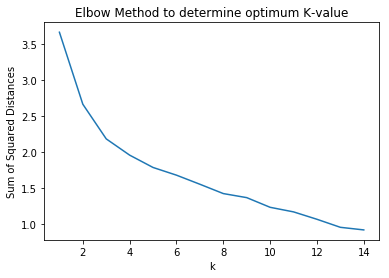

In [39]:
#KClusters
from sklearn.cluster import KMeans

clustering_data = count_final.drop('Area Name', 1)

SSD = []
labels = []
# set number of clusters
for k in range(1, 15):
    #run k-means clustering
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(clustering_data)
    
    SSD.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.
    labels.append(kmeans.labels_)

#Plot K-values and wcss-values
plt.plot(range(1,15), SSD)
plt.title('Elbow Method to determine optimum K-value')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')

plt.show()

In [40]:
#From the graph, we can see that k = 9 is most optimum
kmeans = KMeans(n_clusters = 9, random_state = 0).fit(clustering_data)
label = kmeans.labels_

In [41]:
#Add labels to final df
temp = pd.get_dummies(final[['Venue Category']], prefix = "", prefix_sep = "")
temp['Area Name'] = final['Area Name']

fixed_columns = [temp.columns[-1]] + list(temp.columns[:-1])
temp = temp[fixed_columns]

temp = temp.groupby('Area Name').mean().reset_index()

temp.insert(1, 'Cluster Labels', label)

#Add Latitude and Longitude Information
cluster_final = temp

cluster_final = cluster_final.join(final.set_index('Area Name'), on='Area Name')
cluster_final.head()

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adachi,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,7-Eleven (セブンイレブン 足立島根店),35.782408,139.797570,Convenience Store
0,Adachi,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,FamilyMart (ファミリーマート 島根二丁目店),35.782771,139.799411,Convenience Store
0,Adachi,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,Coco's (ココス 足立島根店),35.782871,139.797551,Restaurant
0,Adachi,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,Seiyu (西友 足立島根店),35.780585,139.797701,Supermarket
0,Adachi,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,FamilyMart (ファミリーマート 島根四丁目店),35.782487,139.792864,Convenience Store


### Visualizing the Clusters on World Map

In [42]:
# create map
map_clusters = folium.Map(zoom_start = 9)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_final['Area Latitude'], cluster_final['Area Longitude'], cluster_final['Area Name'], cluster_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('worldMap.html')

In [43]:
#Open map in another tab
webbrowser.open('file://' + os.path.realpath('worldMap.html'))

True

### Examine Clusters

In [44]:
cluster_final.loc[cluster_final['Cluster Labels'] == 0]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,Discount Suit Company,51.516705,-0.075506,Cocktail Bar
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,1Rebel,51.515569,-0.080040,Gym / Fitness Center
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,Benk + Bo,51.515731,-0.075875,Bakery
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,Planet Organic,51.516827,-0.078636,Organic Grocery
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,The Alchemist,51.515135,-0.079609,Cocktail Bar
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,"Dorsett City, London",51.514008,-0.075715,Hotel
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,Devonshire Club,51.516126,-0.077773,Lounge
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,The Association,51.513733,-0.079132,Coffee Shop
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,Tifinbox,51.516345,-0.077195,Indian Restaurant
1,Aldersgate,0,0.0,0.0,0.000000,0.0,0.0,0.01,0.020000,0.000000,...,0.0,0.01,0.0,0.0,51.515432,-0.076806,Pizza Union,51.517699,-0.077416,Pizza Place


In [45]:
cluster_final.loc[cluster_final['Cluster Labels'] == 1]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
15,East Toronto,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.626243,-79.396962,Hanlan's Point,43.628947,-79.39442,Performing Arts Venue


In [46]:
cluster_final.loc[cluster_final['Cluster Labels'] == 2]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,7-Eleven (セブンイレブン 足立島根店),35.782408,139.797570,Convenience Store
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,FamilyMart (ファミリーマート 島根二丁目店),35.782771,139.799411,Convenience Store
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,Coco's (ココス 足立島根店),35.782871,139.797551,Restaurant
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,Seiyu (西友 足立島根店),35.780585,139.797701,Supermarket
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,FamilyMart (ファミリーマート 島根四丁目店),35.782487,139.792864,Convenience Store
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,マミーマート 足立島根店,35.782584,139.794702,Supermarket
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,割烹 平野屋,35.785670,139.797587,Japanese Restaurant
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,和食さと 足立島根店,35.780609,139.797667,Japanese Restaurant
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,ウエルシア薬局 足立島根店,35.780319,139.797193,Drugstore
0,Adachi,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,35.783703,139.795319,石塚公園,35.783250,139.790372,Park


In [47]:
cluster_final.loc[cluster_final['Cluster Labels'] == 3]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
21,Huntington Park,3,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,33.982704,-118.212034,Yayas,33.980394,-118.210310,Burger Joint
21,Huntington Park,3,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,33.982704,-118.212034,KFC,33.980497,-118.212262,Fried Chicken Joint
21,Huntington Park,3,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,33.982704,-118.212034,The Wrestling Guy Store,33.985545,-118.212905,Accessories Store
21,Huntington Park,3,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,33.982704,-118.212034,Mexico 86,33.979904,-118.208039,Mexican Restaurant
21,Huntington Park,3,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,33.982704,-118.212034,"T. K. Services, Inc.",33.985457,-118.207932,Home Service


In [48]:
cluster_final.loc[cluster_final['Cluster Labels'] == 4]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,光栄軒,35.735570,139.781945,Chinese Restaurant
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,新鮮市場 町屋店,35.741020,139.779047,Grocery Store
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,麺屋 愛心 TOKYO,35.741850,139.781013,Ramen Restaurant
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,Arakawa Park (荒川公園),35.735614,139.783957,Park
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,My Basket (まいばすけっと 荒川4丁目店),35.738698,139.780055,Grocery Store
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,Freshness Burger (フレッシュネスバーガー),35.741668,139.780000,Burger Joint
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,Ministop (ミニストップ 荒川2丁目店),35.737687,139.781851,Convenience Store
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,7-Eleven (セブンイレブン 荒川店),35.736015,139.779654,Convenience Store
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,FamilyMart (ファミリーマート 町屋店),35.740335,139.778819,Convenience Store
3,Arakawa,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,35.737529,139.781310,CAFÉ de CRIÉ Plus,35.739324,139.784083,Café


In [49]:
cluster_final.loc[cluster_final['Cluster Labels'] == 5]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Tacos Mexico,33.974613,-118.187806,Mexican Restaurant
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Baskin-Robbins,33.973359,-118.187856,Ice Cream Shop
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Travelodge Inn & Suites Bell Los Angeles Area,33.976043,-118.186829,Hotel
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Jim's Burgers,33.977516,-118.183361,Burger Joint
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Culichi Town,33.975268,-118.187234,Mexican Restaurant
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Starbucks,33.970607,-118.188322,Coffee Shop
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Pizza Hut,33.972057,-118.187517,Pizza Place
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Jack in the Box,33.970477,-118.187373,Fast Food Restaurant
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Northgate Gonzalez Markets,33.973970,-118.188073,Grocery Store
4,Bell,5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,33.974781,-118.186636,Domino's Pizza,33.971539,-118.188759,Pizza Place


In [50]:
cluster_final.loc[cluster_final['Cluster Labels'] == 6]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,East York Farmers' Market,43.690482,-79.328509,Farmers Market
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,Last Drop Cafe,43.688830,-79.326002,Coffee Shop
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,Subway,43.689830,-79.326023,Sandwich Place
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,Apple cafe,43.689975,-79.326399,Café
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,Cosburn Park Lawn Bowling Club,43.692833,-79.330173,Athletics & Sports
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,Tim Hortons,43.689829,-79.325861,Coffee Shop
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,Panzerotto Pizza,43.689695,-79.323629,Pizza Place
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,Les Anthony Parkette,43.691387,-79.322940,Park
16,East York,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.691339,-79.327821,Paul's Spaghetti,43.692984,-79.333487,Italian Restaurant
37,Queen's Park,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.659980,-79.390369,Mercatto,43.660391,-79.387664,Italian Restaurant


In [51]:
cluster_final.loc[cluster_final['Cluster Labels'] == 7]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,Kenyan (ケニヤン),35.663838,139.699920,Tea Room
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,Au Temps Jadis Creperie,35.664938,139.700416,Café
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,Margaret Howell,35.663431,139.700273,Boutique
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,Zelkova Trees (代々木公園 ケヤキ並木),35.665051,139.698691,Trail
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,Menya Nukaji (麺屋 ぬかじ),35.662691,139.698575,Ramen Restaurant
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,art baru muse,35.662731,139.697381,Café
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,THE SG CLUB,35.664284,139.699167,Cocktail Bar
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,GLOBE SPECS 渋谷店,35.664237,139.699391,Optical Shop
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,Rock no Cocoro (ロックのこころ),35.662498,139.697061,Bar
40,Shibuya,7,0.0,0.02,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.00000,35.664596,139.698711,Zarigani Cafe (ザリガニカフェ),35.664002,139.696625,Café


In [52]:
cluster_final.loc[cluster_final['Cluster Labels'] == 8]

,Area Name,Cluster Labels,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
18,Etobicoke,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.671459,-79.552492,Metro,43.675011,-79.556234,Supermarket
18,Etobicoke,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.671459,-79.552492,Starbucks,43.674358,-79.555189,Coffee Shop
18,Etobicoke,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.671459,-79.552492,Shoppers Drug Mart,43.674209,-79.555424,Pharmacy
18,Etobicoke,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.671459,-79.552492,The Garden,43.671618,-79.553836,Garden
18,Etobicoke,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.671459,-79.552492,Lloyd Manor Park,43.672486,-79.554382,Playground
